In [12]:
import numpy as np
import pandas as pd
import sys

path='/home/jbohn/jupyter/personal/Kernel_Learning/'
sys.path.append(path)

from datetime import date
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from Data.clean_data import clean_quotes

from Features.feature_preprocessing import generate_features_from_quotes

from LOB_Analysis.batch_data import batch_solve_mkl, batch_features
from LOB_Analysis.batch_kernel import train_svm_batch, predict_svm_batch
from LOB_Analysis.iterate_daily_batch import daily_batch



### Fetch Raw Quote Data 

- Quotes for AAPL across  NASDAQ : Exchange N 
- Data in example below is for Jan 2, 2020 however for results data is cleaned and features are generated in bulk across Jan

### Clean & Preprocessing

- Drops market quotes outside of open hours
- Criteria for invalid quotes (inverted spread, zero price or volume)
- Standardizes Participant Timestamp as time index

In [2]:
cleaned_quotes=pd.read_csv(path+'Data/cleaned_AAPL_quotes_2020-01-02.csv',index_col=0)
cleaned_quotes

,Participant_Timestamp,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,...,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:03.296828,140,2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,288805,...,Q,296.19,2.0,Z,296.26,2.0,A,,2,2020-01-02
2020-01-02 09:30:05.489204,141,2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,296557,...,N,296.14,4.0,Z,296.19,4.0,A,,2,2020-01-02
2020-01-02 09:30:05.663684,142,2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,297100,...,Q,296.13,1.0,Z,296.16,2.0,A,,2,2020-01-02
2020-01-02 09:30:06.278858,143,2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,299138,...,Q,296.03,1.0,Z,296.07,4.0,A,,2,2020-01-02
2020-01-02 09:30:14.710996,144,2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,318631,...,Z,295.65,6.0,N,295.74,1.0,A,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175398,87570,2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,30603857,...,Z,300.41,3.0,Q,300.44,4.0,A,,2,2020-01-02
2020-01-02 15:59:46.113982,87571,2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,30643992,...,Z,300.44,2.0,P,300.46,2.0,A,,2,2020-01-02
2020-01-02 15:59:50.118942,87572,2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,30672299,...,Q,300.37,3.0,Q,300.40,4.0,A,,2,2020-01-02
2020-01-02 15:59:52.913707,87573,2020-01-02 15:59:52.914082,N,AAPL,300.29,3.0,300.66,1.0,R,30696052,...,Q,300.36,1.0,Q,300.39,2.0,A,,2,2020-01-02


### Feature Generation

- Generates set of features off quote data 
- Performs time aggregation to 5 second 
- Labels outcome; price direction relative to next interval

In [3]:
labelled_data=generate_features_from_quotes(cleaned_quotes,time_agg=5,save=False)
labelled_data

,Exchange,Best_Bid_Price,Best_Offer_Price,Best_Bid_Size,Best_Offer_Size,Best_Bid_Size_Diff,Best_Offer_Size_Diff,Spread,Spread_Change,WBP,WAP,VWAP,AWS,Anomaly,Rolling_Imbalance,p_time,Best_Next_Bid,Best_Next_Offer,outcome
last_interval,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:25,N,295.630000,295.700000,1.166667,2.000000,0.000000,0.000000,0.070000,-0.006667,6.499704,9.833238,8.166471,3.333533,0.500000,1.861111,2020-01-02 09:30:29.749870,295.708000,295.790000,1
2020-01-02 09:30:30,N,295.708000,295.790000,1.400000,1.600000,-0.200000,0.200000,0.082000,0.010000,7.999256,6.999331,7.499293,-0.999925,0.200000,1.040000,2020-01-02 09:30:34.956484,295.746000,295.849200,0
2020-01-02 09:30:35,N,295.746000,295.849200,1.800000,2.200000,0.040000,0.080000,0.103200,-0.001600,8.559996,10.679909,9.619953,2.119913,0.400000,1.437333,2020-01-02 09:30:39.045859,295.706087,295.764348,0
2020-01-02 09:30:40,N,295.706087,295.764348,1.652174,2.173913,0.000000,-0.130435,0.058261,0.001304,8.521808,10.956735,9.739272,2.434927,0.304348,1.434783,2020-01-02 09:30:43.711474,295.791522,295.848043,1
2020-01-02 09:30:45,N,295.791522,295.848043,2.500000,8.043478,-0.021739,0.000000,0.056522,-0.001522,11.999611,40.325759,26.162685,28.326149,0.239130,5.345652,2020-01-02 09:30:49.468143,295.825294,295.905294,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:25,N,300.420000,300.426667,9.666667,1.000000,0.333333,0.000000,0.006667,-0.003333,34.001265,5.333344,19.667305,-28.667921,0.000000,0.309829,2020-01-02 15:59:28.823431,300.410000,300.440000,0
2020-01-02 15:59:40,N,300.410000,300.440000,3.000000,4.000000,-1.000000,3.000000,0.030000,0.030000,35.001931,7.999933,21.500932,-27.001997,0.000000,0.415385,2020-01-02 15:59:41.175398,300.440000,300.460000,0
2020-01-02 15:59:45,N,300.440000,300.460000,2.000000,2.000000,-1.000000,-2.000000,0.020000,-0.010000,33.998336,8.999401,21.498868,-24.998935,0.000000,0.548718,2020-01-02 15:59:46.113982,300.365000,300.395000,-1


### Batch Features

- For computational feasiblity will retrain model off batched data looking to evaluate performance in subsequent interval
- Batches features and outcomes in size batch_size which model will be trained from

### Train Single Kernel across batched dataset

In [2]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=1
batch_size=300


single_gaussian_accuracy,single_gaussian_precision=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:25 complete with weights  [1.]
Batch  300 Last Interval 2020-01-02 09:55:40 complete with weights  [1.]
Batch  600 Last Interval 2020-01-02 10:20:45 complete with weights  [1.]
Batch  900 Last Interval 2020-01-02 10:46:05 complete with weights  [1.]
Batch  1200 Last Interval 2020-01-02 11:11:45 complete with weights  [1.]
Batch  1500 Last Interval 2020-01-02 11:37:55 complete with weights  [1.]
Batch  1800 Last Interval 2020-01-02 12:04:35 complete with weights  [1.]
Batch  2100 Last Interval 2020-01-02 12:31:20 complete with weights  [1.]
Batch  2400 Last Interval 2020-01-02 12:59:30 complete with weights  [1.]
Batch  2700 Last Interval 2020-01-02 13:28:20 complete with weights  [1.]
Batch  3000 Last Interval 2020-01-02 13:56:10 complete with weights  [1.]
Batch  3300 Last Inter

In [3]:
start='2020-01-01'
end='2020-01-30'

kernel_type='linear'
order=1
batch_size=300


single_linear_accuracy,single_linear_precision=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:25 complete with weights  [1.]
Batch  300 Last Interval 2020-01-02 09:55:40 complete with weights  [1.]
Batch  600 Last Interval 2020-01-02 10:20:45 complete with weights  [1.]
Batch  900 Last Interval 2020-01-02 10:46:05 complete with weights  [1.]
Batch  1200 Last Interval 2020-01-02 11:11:45 complete with weights  [1.]
Batch  1500 Last Interval 2020-01-02 11:37:55 complete with weights  [1.]
Batch  1800 Last Interval 2020-01-02 12:04:35 complete with weights  [1.]
Batch  2100 Last Interval 2020-01-02 12:31:20 complete with weights  [1.]
Batch  2400 Last Interval 2020-01-02 12:59:30 complete with weights  [1.]
Batch  2700 Last Interval 2020-01-02 13:28:20 complete with weights  [1.]
Batch  3000 Last Interval 2020-01-02 13:56:10 complete with weights  [1.]
Batch  3300 Last Inter

In [18]:
single_gaussian_accuracy_df=pd.DataFrame.from_dict(single_gaussian_accuracy,orient='index',columns=['gaussian'])
single_gaussian_accuracy_df['date']=[i.date() for i in pd.to_datetime(single_gaussian_accuracy_df.index)]
single_gaussian_precision_df=pd.DataFrame.from_dict(single_gaussian_precision,orient='index',columns=['gaussian'])
single_gaussian_precision_df['date']=[i.date() for i in pd.to_datetime(single_gaussian_precision_df.index)]

single_linear_accuracy_df=pd.DataFrame.from_dict(single_linear_accuracy,orient='index',columns=['linear'])
single_linear_accuracy_df['date']=[i.date() for i in pd.to_datetime(single_linear_accuracy_df.index)]
single_linear_precision_df=pd.DataFrame.from_dict(single_linear_precision,orient='index',columns=['linear'])
single_linear_precision_df['date']=[i.date() for i in pd.to_datetime(single_linear_precision_df.index)]

single_gaussian_accuracy_df=single_gaussian_accuracy_df[single_gaussian_accuracy_df['date']<date(2020,1,3)]
single_gaussian_precision_df=single_gaussian_precision_df[single_gaussian_precision_df['date']<date(2020,1,3)]
single_linear_accuracy_df=single_linear_accuracy_df[single_linear_accuracy_df['date']<date(2020,1,3)]
single_linear_precision_df=single_linear_precision_df[single_linear_precision_df['date']<date(2020,1,3)]

single_gaussian_accuracy_df.index=pd.to_datetime(single_gaussian_accuracy_df.index)
single_gaussian_precision_df.index=pd.to_datetime(single_gaussian_precision_df.index)
single_linear_accuracy_df.index=pd.to_datetime(single_linear_accuracy_df.index)
single_linear_precision_df.index=pd.to_datetime(single_linear_precision_df.index)




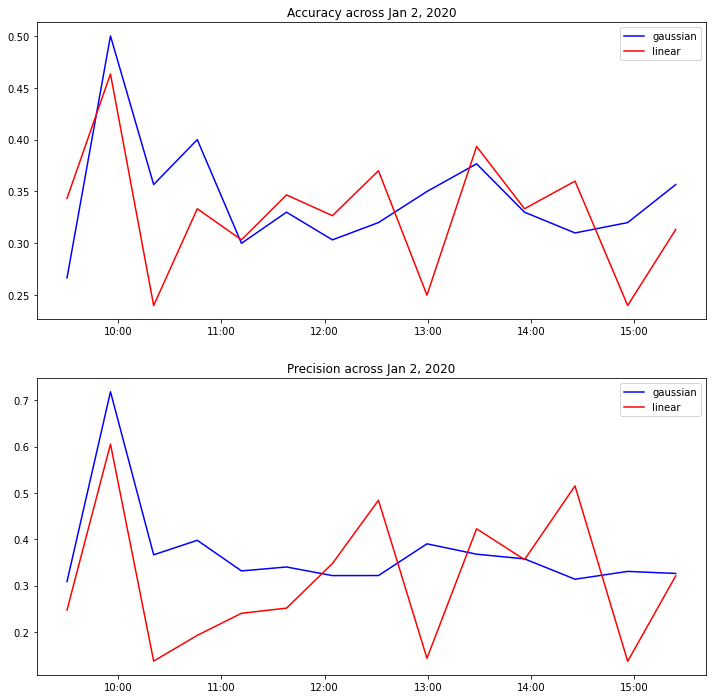

In [20]:
fig,ax=plt.subplots(2,1,figsize=(12,12))
ax[0].plot(single_gaussian_accuracy_df.index,single_gaussian_accuracy_df['gaussian'],label='gaussian',color='blue')
ax[0].plot(single_linear_accuracy_df.index,single_linear_accuracy_df['linear'],label='linear',color='red')
ax[0].set_title('Accuracy across Jan 2, 2020')
ax[0].legend()
ax[1].plot(single_gaussian_precision_df.index,single_gaussian_precision_df['gaussian'],label='gaussian',color='blue')
ax[1].plot(single_linear_precision_df.index,single_linear_precision_df['linear'],label='linear',color='red')
ax[1].set_title('Precision across Jan 2, 2020')
ax[1].legend()
xfmt = DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

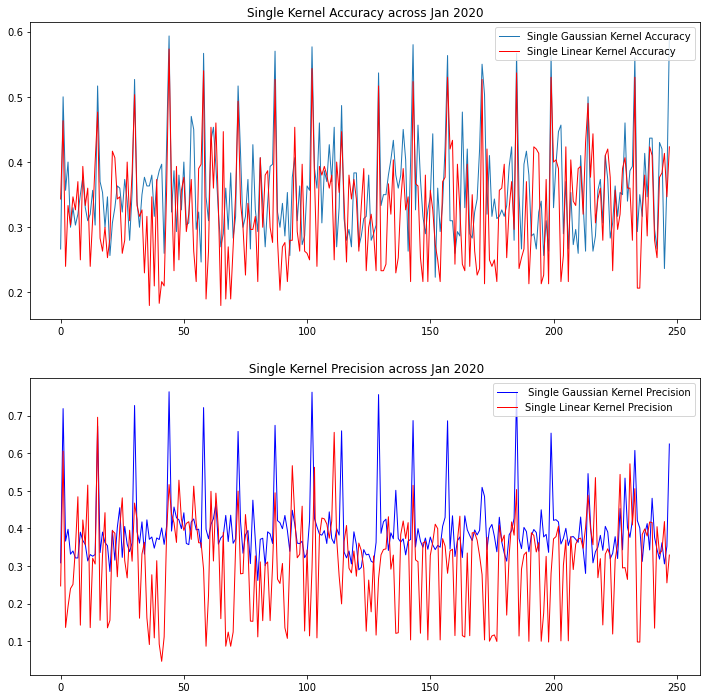

In [21]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(list(single_gaussian_accuracy.values()),lw=1,label='Single Gaussian Kernel Accuracy')
axis[0].plot(list(single_linear_accuracy.values()),lw=1,label='Single Linear Kernel Accuracy',color='red')
axis[0].set_title('Single Kernel Accuracy across Jan 2020')
axis[1].plot(list(single_gaussian_precision.values()),lw=1,label=' Single Gaussian Kernel Precision',color='blue')
axis[1].plot(list(single_linear_precision.values()),lw=1,label='Single Linear Kernel Precision',color='red')
axis[1].set_title(' Single Kernel Precision across Jan 2020')
axis[0].legend()
axis[1].legend()
# xfmt = DateFormatter('%d-%m-%y')
# axis[0].xaxis.set_major_formatter(xfmt)
# axis[1].xaxis.set_major_formatter(xfmt)

In [22]:
accuracy_df=pd.DataFrame.from_dict(single_gaussian_accuracy,orient='index')
accuracy_df.describe()

,0
count,248.000000
mean,0.357997
std,0.075706
min,0.223333
25%,0.303333
50%,0.346667
75%,0.393333
max,0.593333


In [23]:
precision_df=pd.DataFrame.from_dict(single_gaussian_precision,orient='index')
precision_df.describe()

,0
count,248.000000
mean,0.397087
std,0.090302
min,0.261843
25%,0.347382
50%,0.377090
75%,0.411151
max,0.763242


In [24]:
accuracy_df=pd.DataFrame.from_dict(single_linear_accuracy,orient='index')
accuracy_df.describe()

,0
count,248.000000
mean,0.330538
std,0.084743
min,0.180000
25%,0.255833
50%,0.333333
75%,0.390000
max,0.573333


In [25]:
precision_df=pd.DataFrame.from_dict(single_linear_precision,orient='index')
precision_df.describe()

,0
count,248.000000
mean,0.310612
std,0.128838
min,0.046944
25%,0.216110
50%,0.331458
75%,0.390889
max,0.695483


### Multi-Kernel Training and Evaluation (3 Kernels)


In [27]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=3
batch_size=300


gaussian_accuracy_3,gaussian_precision_3=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:25 complete with weights  [0.29376028 0.35283965 0.35340007]
Batch  300 Last Interval 2020-01-02 09:55:40 complete with weights  [0.59873964 0.28183869 0.11942167]
Batch  600 Last Interval 2020-01-02 10:20:45 complete with weights  [0.         0.47698214 0.52301786]
Batch  900 Last Interval 2020-01-02 10:46:05 complete with weights  [0.42711282 0.31685046 0.25603672]
Batch  1200 Last Interval 2020-01-02 11:11:45 complete with weights  [0.         0.56824264 0.43175736]
Batch  1500 Last Interval 2020-01-02 11:37:55 complete with weights  [0.         0.45946546 0.54053454]
Batch  1800 Last Interval 2020-01-02 12:04:35 complete with weights  [0.        0.3766617 0.6233383]
Batch  2100 Last Interval 2020-01-02 12:31:20 complete with weights  [0.38045003 0.31535758 0.30419239]
Batch  

In [28]:
accuracy_df=pd.DataFrame.from_dict(gaussian_accuracy_3,orient='index')
accuracy_df.describe()

,0
count,248.000000
mean,0.378548
std,0.081557
min,0.240000
25%,0.333333
50%,0.360000
75%,0.406667
max,0.820000


In [29]:
precision_df=pd.DataFrame.from_dict(gaussian_precision_3,orient='index')
precision_df.describe()


,0
count,248.000000
mean,0.403145
std,0.100004
min,0.275044
25%,0.353274
50%,0.383533
75%,0.411211
max,0.845136


### Multiple Kernel (5) Gaussian and Polynomials

In [30]:
start='2020-01-01'
end='2020-01-30'

kernel_type='gaussian'
order=5
batch_size=300


gaussian_accuracy_5,gaussian_precision_5=daily_batch(start,end,kernel_type,order,batch_size)

[Errno 2] No such file or directory: '/home/jbohn/jupyter/personal/Kernel_Learning/Features/Cleaned_Features/labeled_data_2020-01-01.csv'
No data for 2020-01-01 00:00:00
Batch  0 Last Interval 2020-01-02 09:30:25 complete with weights  [0.19206941 0.20198461 0.20203091 0.2018675  0.20204757]
Batch  300 Last Interval 2020-01-02 09:55:40 complete with weights  [0.89835499 0.10164501 0.         0.         0.        ]
Batch  600 Last Interval 2020-01-02 10:20:45 complete with weights  [0.         0.23198838 0.24715122 0.256671   0.26418939]
Batch  900 Last Interval 2020-01-02 10:46:05 complete with weights  [0.3041313  0.25233938 0.18099569 0.14163701 0.12089662]
Batch  1200 Last Interval 2020-01-02 11:11:45 complete with weights  [0.         0.28098497 0.25614348 0.23847257 0.22439898]
Batch  1500 Last Interval 2020-01-02 11:37:55 complete with weights  [0.         0.2238316  0.24496823 0.26042193 0.27077824]
Batch  1800 Last Interval 2020-01-02 12:04:35 complete with weights  [0.        

In [31]:
accuracy_df=pd.DataFrame.from_dict(gaussian_accuracy_5,orient='index')
accuracy_df.describe()

,0
count,248.000000
mean,0.375363
std,0.076560
min,0.233333
25%,0.330000
50%,0.360000
75%,0.404167
max,0.623333


In [32]:
precision_df=pd.DataFrame.from_dict(gaussian_precision_5,orient='index')
precision_df.describe()


,0
count,248.000000
mean,0.402809
std,0.098309
min,0.266358
25%,0.352605
50%,0.379627
75%,0.411354
max,0.776390


In [33]:
gaussian_accuracy_3_df=pd.DataFrame.from_dict(gaussian_accuracy_3,orient='index',columns=['gaussian'])
gaussian_accuracy_3_df['date']=[i.date() for i in pd.to_datetime(gaussian_accuracy_3_df.index)]
gaussian_precision_3_df=pd.DataFrame.from_dict(gaussian_precision_3,orient='index',columns=['gaussian'])
gaussian_precision_3_df['date']=[i.date() for i in pd.to_datetime(gaussian_precision_3_df.index)]

gaussian_accuracy_5_df=pd.DataFrame.from_dict(gaussian_accuracy_5,orient='index',columns=['linear'])
gaussian_accuracy_5_df['date']=[i.date() for i in pd.to_datetime(gaussian_accuracy_5_df.index)]
gaussian_precision_5_df=pd.DataFrame.from_dict(gaussian_precision_5,orient='index',columns=['linear'])
gaussian_precision_5_df['date']=[i.date() for i in pd.to_datetime(gaussian_precision_5_df.index)]

gaussian_accuracy_3_df=gaussian_accuracy_3_df[gaussian_accuracy_3_df['date']<date(2020,1,3)]
gaussian_precision_3_df=gaussian_precision_3_df[gaussian_precision_3_df['date']<date(2020,1,3)]
gaussian_accuracy_5_df=gaussian_accuracy_5_df[gaussian_accuracy_5_df['date']<date(2020,1,3)]
gaussian_precision_5_df=gaussian_precision_5_df[gaussian_precision_5_df['date']<date(2020,1,3)]

gaussian_accuracy_3_df.index=pd.to_datetime(gaussian_accuracy_3_df.index)
gaussian_precision_3_df.index=pd.to_datetime(gaussian_precision_3_df.index)
gaussian_accuracy_5_df.index=pd.to_datetime(gaussian_accuracy_5_df.index)
gaussian_precision_5_df.index=pd.to_datetime(gaussian_precision_5_df.index)

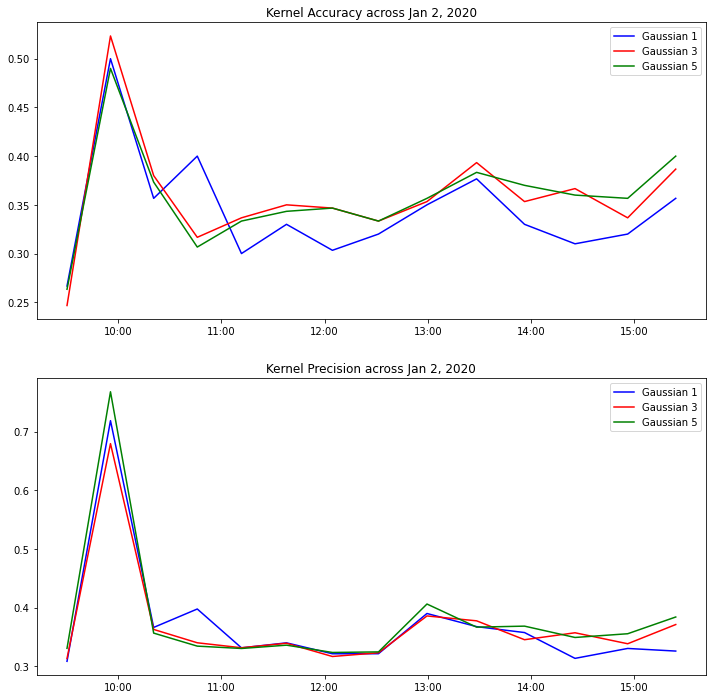

In [39]:
fig,ax=plt.subplots(2,1,figsize=(12,12))
ax[0].plot(single_gaussian_accuracy_df.index,single_gaussian_accuracy_df['gaussian'],label='Gaussian 1',color='blue')
ax[0].plot(gaussian_accuracy_3_df.index,gaussian_accuracy_3_df['gaussian'],label='Gaussian 3',color='red')
ax[0].plot(gaussian_accuracy_5_df.index,gaussian_accuracy_5_df['linear'],label='Gaussian 5',color='green')
ax[0].set_title('Kernel Accuracy across Jan 2, 2020')
ax[0].legend()
ax[1].plot(single_gaussian_precision_df.index,single_gaussian_precision_df['gaussian'],label='Gaussian 1',color='blue')
ax[1].plot(gaussian_precision_3_df.index,gaussian_precision_3_df['gaussian'],label='Gaussian 3',color='red')
ax[1].plot(gaussian_precision_5_df.index,gaussian_precision_5_df['linear'],label='Gaussian 5',color='green')
ax[1].set_title('Kernel Precision across Jan 2, 2020')
ax[1].legend()
xfmt = DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)

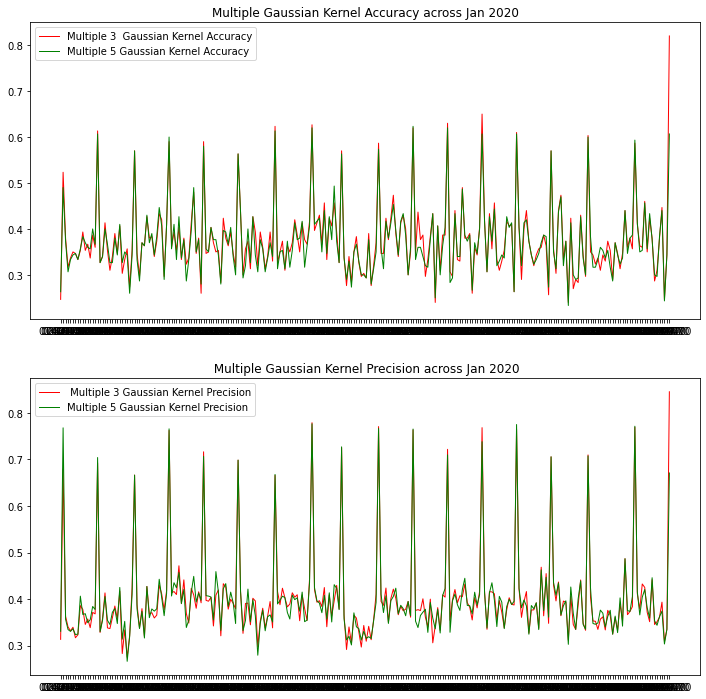

In [40]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(list(gaussian_accuracy_3.keys()),list(gaussian_accuracy_3.values()),lw=1,label='Multiple 3  Gaussian Kernel Accuracy',color='red')
axis[0].plot(list(gaussian_accuracy_5.keys()),list(gaussian_accuracy_5.values()),lw=1,label='Multiple 5 Gaussian Kernel Accuracy',color='green')
axis[0].set_title('Multiple Gaussian Kernel Accuracy across Jan 2020')
axis[1].plot(list(gaussian_precision_3.keys()),list(gaussian_precision_3.values()),lw=1,label=' Multiple 3 Gaussian Kernel Precision',color='red')
axis[1].plot(list(gaussian_precision_5.keys()),list(gaussian_precision_5.values()),lw=1,label='Multiple 5 Gaussian Kernel Precision',color='green')
axis[1].set_title(' Multiple Gaussian Kernel Precision across Jan 2020')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)